In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from utils import model,tools,pde,validation
import seaborn as sns

import pickle as pkl
import torch
import numpy as np
from torch.autograd import Variable
import matplotlib as mpl
import pandas as pd
import json
from utils import groundtruth as gt

In [2]:
torch.set_default_dtype(torch.float64)

In [3]:
Nv = 256
val_x=np.arange(-3,3,6/Nv).reshape([Nv,1])
val_y=np.arange(-3,3,6/Nv).reshape([Nv,1])
t_vx = Variable(torch.from_numpy(val_x))
t_vy = Variable(torch.from_numpy(val_y))



#Generate grids to output graph
val_ms_x, val_ms_y = np.meshgrid(val_x, val_y)
r = np.sqrt(np.power(val_ms_x,2)+np.power(val_ms_y,2))
mask = ~np.logical_and(r>=1.0,r<=3.0)
print(mask.shape)
plot_val_x = np.ravel(val_ms_x).reshape(-1,1)
plot_val_y = np.ravel(val_ms_y).reshape(-1,1)

u_plot_values_tmp,c_plot_values_tmp,p_plot_values,_,_ = gt.data_gen_interior(np.concatenate([plot_val_x,plot_val_y],axis=1))

u_plot_values = u_plot_values_tmp.reshape([Nv,Nv]).copy()
c_plot_values = c_plot_values_tmp.reshape([Nv,Nv]).copy()
u_plot_values[mask] = np.nan
c_plot_values[mask] = np.nan
#u_plot_values = np.array([generate_ugt(plot_val_x[ind],plot_val_y[ind]) for ind in range(len(plot_val_x))]).reshape([Nv,Nv])
#c_plot_values = np.array([generate_cgt(plot_val_x[ind],plot_val_y[ind]) for ind in range(len(plot_val_x))]).reshape([Nv,Nv])

t_val_vx = Variable(torch.from_numpy(plot_val_x))
t_val_vy = Variable(torch.from_numpy(plot_val_y))

(256, 256)


<lambdifygenerated-2>:2: RuntimeWarning: invalid value encountered in scalar divide
  return -100.0*x2*(0.01*sqrt(x1**2 + x2**2) - 0.01)*(sqrt(x1**2 + x2**2) - 3)/sqrt(x1**2 + x2**2)
<lambdifygenerated-3>:2: RuntimeWarning: invalid value encountered in scalar divide
  return x2*(0.01*sqrt(x1**2 + x2**2) - 0.01)*(sqrt(x1**2 + x2**2) - 3)/sqrt(x1**2 + x2**2)
<lambdifygenerated-4>:2: RuntimeWarning: invalid value encountered in scalar divide
  return x1**2 + x2**2 + x2*(-0.02*x1**2*(sqrt(x1**2 + x2**2) - 3)/(x1**2 + x2**2)**2 - 0.02*x1**2*(sqrt(x1**2 + x2**2) - 1)/(x1**2 + x2**2)**2 + 0.02*x1**2/(x1**2 + x2**2)**(3/2) - 0.01*(x1**2/(x1**2 + x2**2) - 1)*(sqrt(x1**2 + x2**2) - 3)/(x1**2 + x2**2) - 0.01*(x1**2/(x1**2 + x2**2) - 1)*(sqrt(x1**2 + x2**2) - 1)/(x1**2 + x2**2) + 0.01*(3*x1**2/(x1**2 + x2**2) - 1)*(sqrt(x1**2 + x2**2) - 3)*(sqrt(x1**2 + x2**2) - 1)/(x1**2 + x2**2)**(3/2)) + x2*(-0.02*x2**2*(sqrt(x1**2 + x2**2) - 3)/(x1**2 + x2**2)**2 - 0.02*x2**2*(sqrt(x1**2 + x2**2) - 1)/(x1**2 +

In [4]:
u_L2 = np.sqrt(np.nanmean(np.square(u_plot_values)))
c_L2 = np.sqrt(np.nanmean(np.square(c_plot_values)))

#u_Lm = np.max(np.abs(u_plot_values[u_plot_values!=np.nan]))
#c_Lm = np.max(np.abs(c_plot_values[c_plot_values!=np.nan]))
u_Lm = np.nanmax(np.abs(u_plot_values))
c_Lm = np.nanmax(np.abs(c_plot_values))

In [5]:
c_Lm,c_L2

(0.9999389648437502, 0.5166392708903095)

In [6]:
alc = torch.load("/Users/dual/Documents/cpinn_backup_20230624/LinearEx2_annulus/results/AL/t12/u.pt")
alu = torch.load("/Users/dual/Documents/cpinn_backup_20230624/LinearEx2_annulus/results/AL/t12/y.pt")

pc = torch.load("/Users/dual/Documents/cpinn_backup_20230624/LinearEx2_annulus/results/penalty/t9/u.pt")
pu = torch.load("/Users/dual/Documents/cpinn_backup_20230624/LinearEx2_annulus/results/penalty/t9/y.pt")

#need better result for AONN
AONN_u = torch.load('/Users/dual/Documents/cpinn_backup_20230624/LinearEx2_annulus/results/AONN/t6_frd2/y.pt')
AONN_c = torch.load('/Users/dual/Documents/cpinn_backup_20230624/LinearEx2_annulus/results/AONN/t6_frd2/u.pt')

cc = torch.load("/Users/dual/Documents/cpinn_backup_20230624/LinearEx2_annulus/results/cpinn/t4/p.pt")
cu = torch.load("/Users/dual/Documents/cpinn_backup_20230624/LinearEx2_annulus/results/cpinn/t4/y.pt")

In [38]:

sns.set_theme(style='white')
def plot_2D_data(fig,ax,data,title="",xlabel="",ylabel="",barlabel="",format=None,titlefs=25,labelfs=35):
    mpl.rcParams['font.size'] = titlefs
    plot_data = data.copy()
    plot_data[mask] = np.nan
    im = ax.imshow(plot_data,cmap=cm.coolwarm)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_axis_off()
    mpl.rcParams['font.size'] = labelfs
    cbar = fig.colorbar(im, ax=ax, label=barlabel,shrink=0.82,pad=0.03,format=format,spacing="proportional")
    cbar.ax.tick_params(labelsize=labelfs)

def plot_2D_func(fig,ax,net,title="",xlabel="",ylabel="",barlabel="",format=None,titlefs=25,labelfs=35):
    pt_u = net(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])
    plot_2D_data(fig,ax,pt_u,title,xlabel,ylabel,barlabel,format=format,titlefs=titlefs,labelfs=labelfs)

def plot_err(fig,ax,net,data,title="",xlabel="",ylabel="",barlabel="",format=None,titlefs=25,labelfs=35):
    pt_u = net(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])
    err = np.abs(pt_u-data)
    plot_2D_data(fig,ax,err,title,xlabel,ylabel,barlabel,format=format,titlefs=titlefs,labelfs=labelfs)

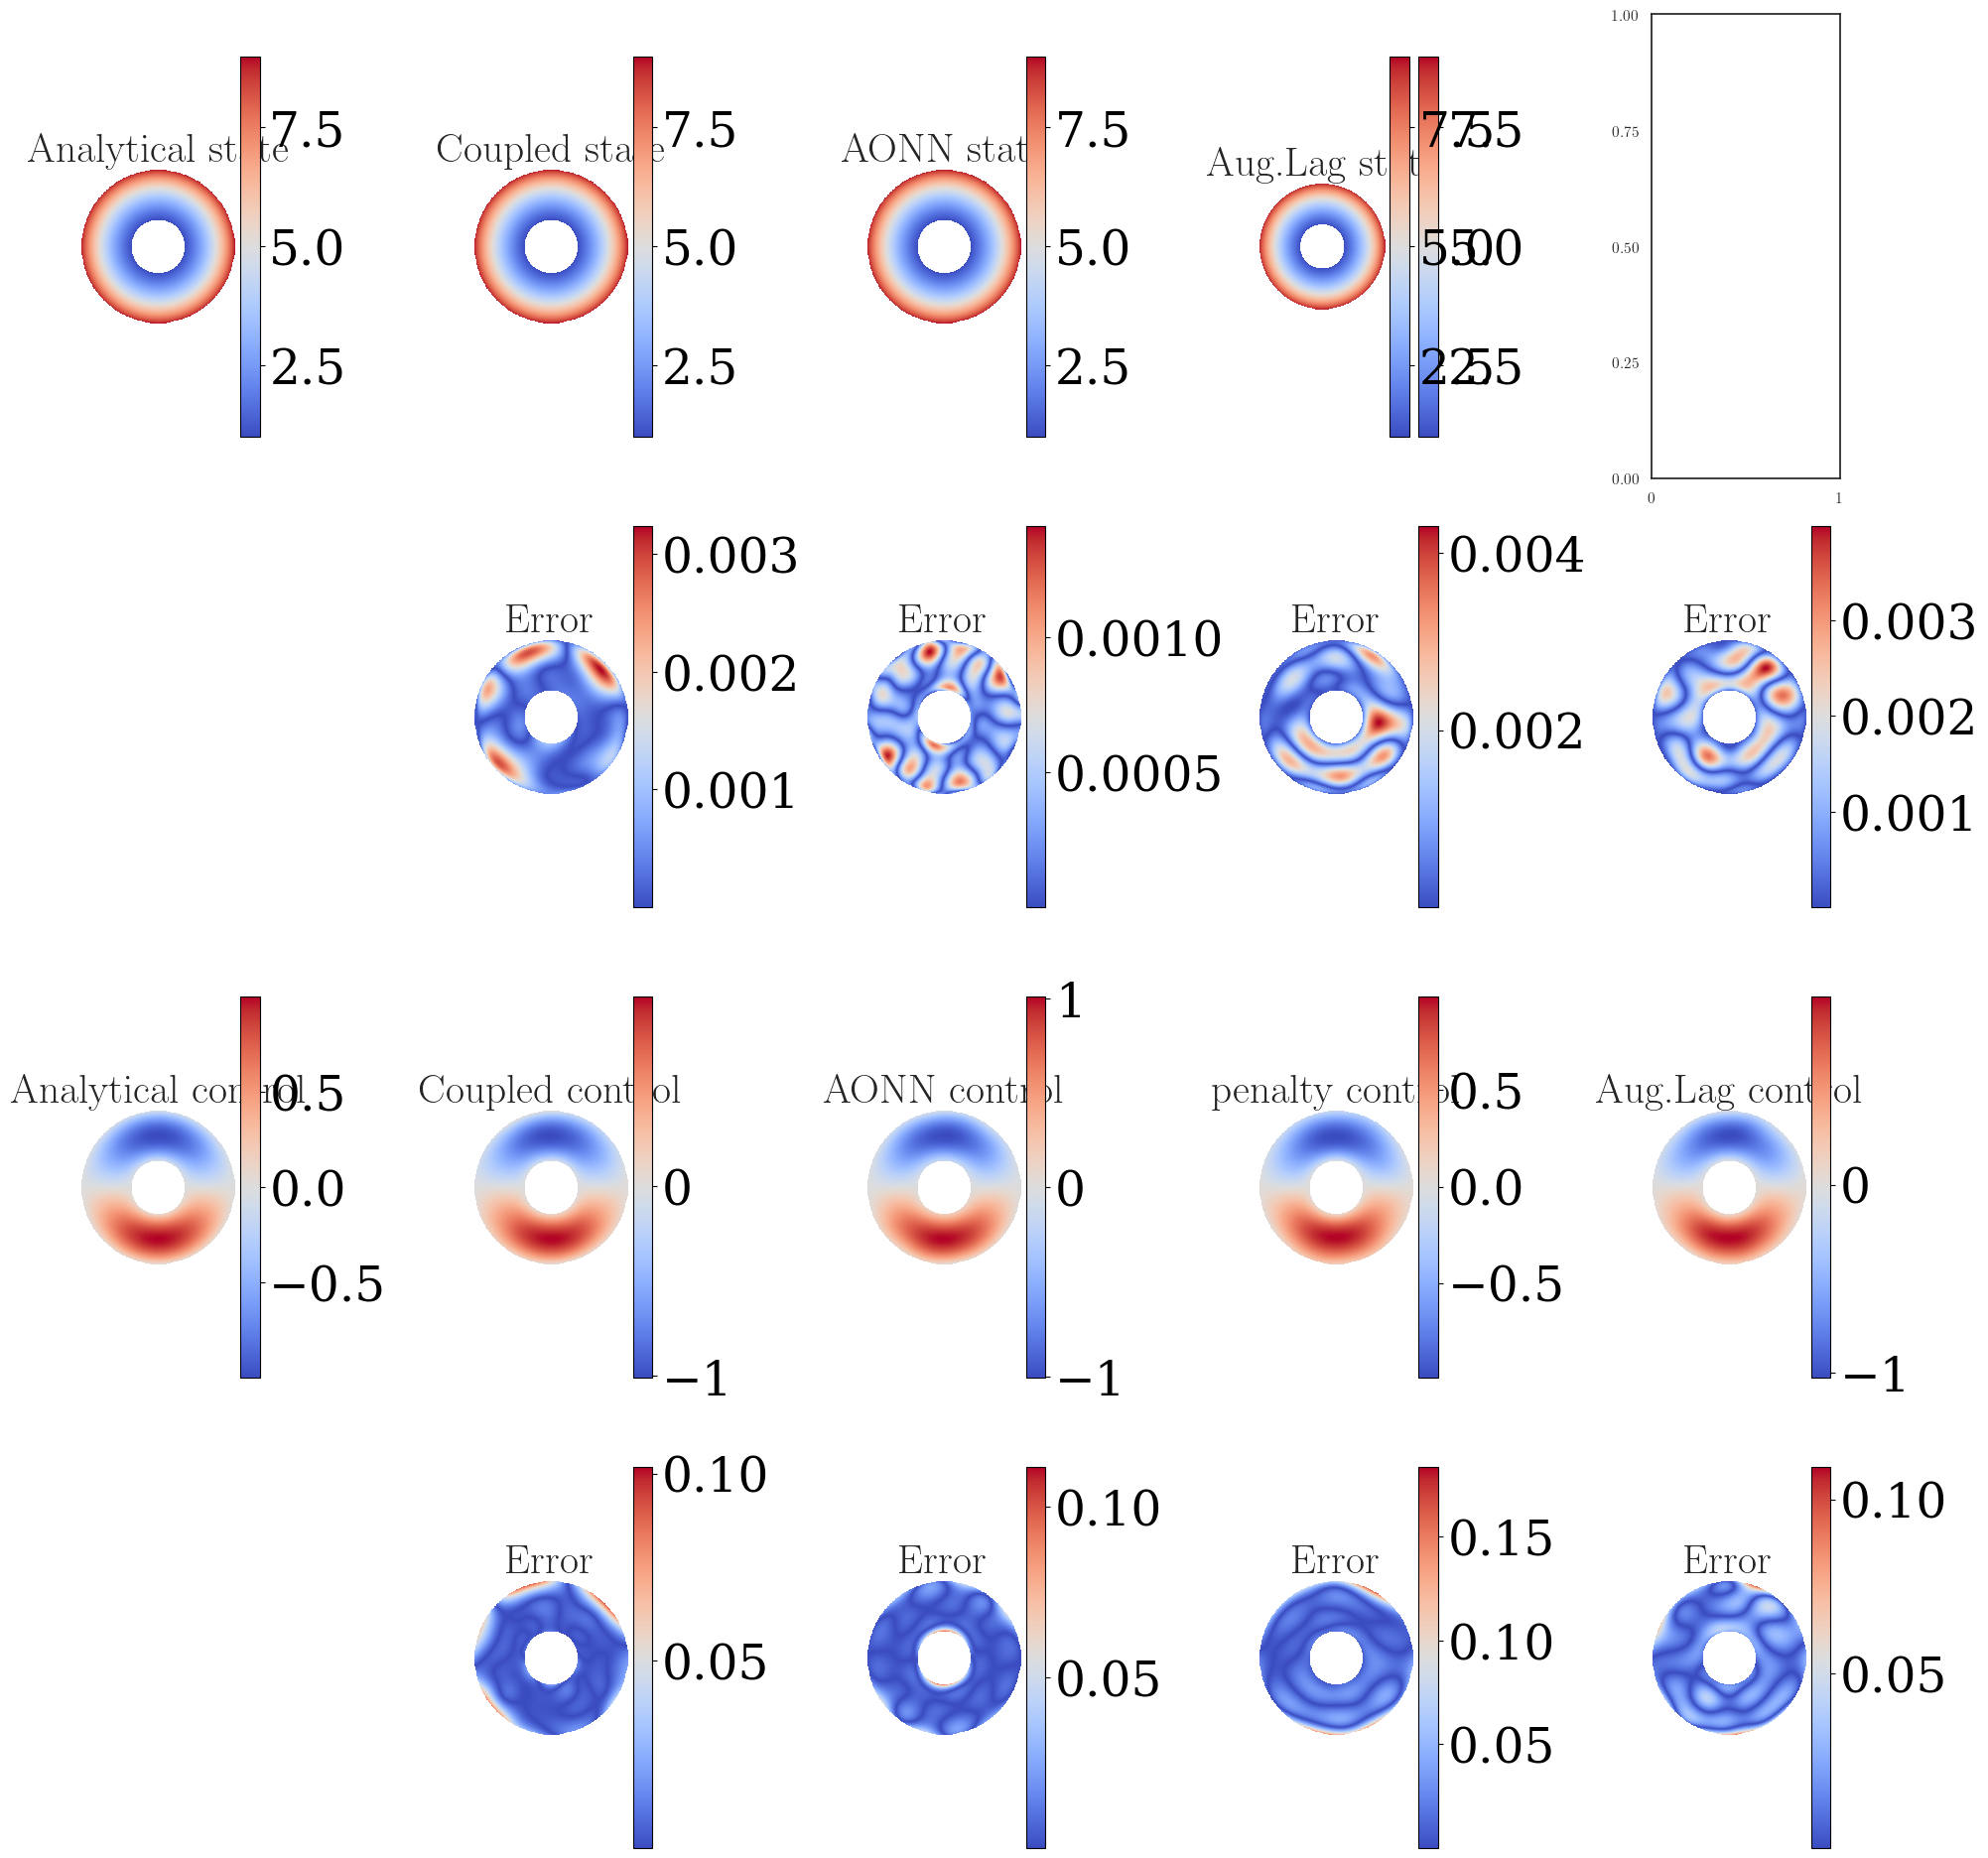

In [46]:
fig, ax = plt.subplots(4,5,figsize=[20,20])
mpl.rcdefaults()
mpl.rcParams['font.family']='serif'
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.variant'] = 'normal'
mpl.rcParams['font.weight'] = 'book'
mpl.rcParams['font.size'] = 9

#fig,ax = plt.subplots(1,2)
plot_2D_data(fig,ax[0,0],u_plot_values,'Analytical state')
plot_2D_func(fig,ax[0,1],cu,'Coupled state')
plot_2D_func(fig,ax[0,2],AONN_u,'AONN state')
plot_2D_func(fig,ax[0,3],pu,'penalty state')
plot_2D_func(fig,ax[0,3],alu,'Aug.Lag state')

fig.delaxes(ax[1,0])
plot_err(fig,ax[1,1],cu,u_plot_values,'Error')
plot_err(fig,ax[1,2],AONN_u,u_plot_values,"Error")
plot_err(fig,ax[1,3],pu,u_plot_values,"Error")
plot_err(fig,ax[1,4],alu,u_plot_values,"Error")

plot_2D_data(fig,ax[2,0],c_plot_values,'Analytical control')

cout = torch.clamp(cc(t_val_vx,t_val_vy)*(-100.0),-999999,99999.0).detach().numpy().reshape([Nv,Nv])
aout = AONN_c(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])
aout = torch.clamp(AONN_c(t_val_vx,t_val_vy),-99999.0,99999.0).detach().numpy().reshape([Nv,Nv])
plot_2D_data(fig,ax[2,1],cout,'Coupled control')
plot_2D_data(fig,ax[2,2],aout,'AONN control')

plot_2D_func(fig,ax[2,3],pc,'penalty control')
plot_2D_func(fig,ax[2,4],alc,'Aug.Lag control')

fig.delaxes(ax[3,0])
plot_2D_data(fig,ax[3,1],np.abs(cout-c_plot_values),"Error")
plot_2D_data(fig,ax[3,2],np.abs(aout-c_plot_values),"Error")
plot_err(fig,ax[3,3],pc,c_plot_values,"Error")
plot_err(fig,ax[3,4],alc,c_plot_values,"Error")



plt.tight_layout(h_pad=0)
plt.savefig("test3.png",dpi=300)

plt.show()

In [10]:
cout = ((cc(t_val_vx,t_val_vy).detach().numpy())*(-100)).reshape([Nv,Nv])
aout = ((AONN_c(t_val_vx,t_val_vy).detach().numpy())).reshape([Nv,Nv])

Lmerr = [
    np.nanmax(np.abs(cu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-u_plot_values))/u_Lm,
    np.nanmax(np.abs(cout-c_plot_values))/c_Lm,
    np.nanmax(np.abs(AONN_u(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-u_plot_values))/u_Lm,
    np.nanmax(np.abs(aout-c_plot_values))/c_Lm,
    np.nanmax(np.abs(pu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-u_plot_values))/u_Lm,
    np.nanmax(np.abs(pc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-c_plot_values))/c_Lm,
    np.nanmax(np.abs(alu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-u_plot_values))/u_Lm,
    np.nanmax(np.abs(alc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-c_plot_values))/c_Lm,
]

L2err = [
    1.0*np.sqrt(np.nanmean(np.square(cu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-u_plot_values)))/u_L2,
    1.0*np.sqrt(np.nanmean(np.square(cout-c_plot_values)))/c_L2,
    1.0*np.sqrt(np.nanmean(np.square(AONN_u(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-u_plot_values)))/u_L2,
    1.0*np.sqrt(np.nanmean(np.square(aout-c_plot_values)))/c_L2,
    1.0*np.sqrt(np.nanmean(np.square(pu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-u_plot_values)))/u_L2,
    1.0*np.sqrt(np.nanmean(np.square(pc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-c_plot_values)))/c_L2,
    1.0*np.sqrt(np.nanmean(np.square(alu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-u_plot_values)))/u_L2,
    1.0*np.sqrt(np.nanmean(np.square(alc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-c_plot_values)))/c_L2,
]

In [11]:
L2err

[0.0001350071895612297,
 0.028269808576958478,
 8.777693761502591e-05,
 0.02797218891573788,
 0.00026453928309652923,
 0.057733770261021944,
 0.0002527653981864967,
 0.03939672179382272]

In [12]:
Lmerr

[0.0002561251891989179,
 0.07551870577521566,
 0.0001567070033239304,
 0.11163305822976423,
 0.00047754765104516633,
 0.1832652714418296,
 0.0004421011832845699,
 0.10918407554377228]

In [13]:
with torch.no_grad():
    cost = pde.cost_mse(cu,u_plot_values_tmp,cc(t_val_vx,t_val_vy)*(-100),0.01,t_val_vx,t_val_vy)
    print(cost)

tensor(0.0032)


In [14]:
with torch.no_grad():
    cost = pde.cost_mse(alu,u_plot_values_tmp,alc(t_val_vx,t_val_vy),0.01,t_val_vx,t_val_vy)
    print(cost)

tensor(0.0016)


In [15]:
with torch.no_grad():
    cost = pde.cost_mse(AONN_u,u_plot_values_tmp,AONN_c(t_val_vx,t_val_vy),0.01,t_val_vx,t_val_vy)
    print(cost)

tensor(0.0016)


In [62]:
alcout = ((alc(t_val_vx,t_val_vy).detach().numpy())).reshape([Nv,Nv])
#print(np.nanmax(np.abs(alc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-c_plot_values)))
print(np.nanmax(np.abs(alcout-c_plot_values)))

1.2578815129748135


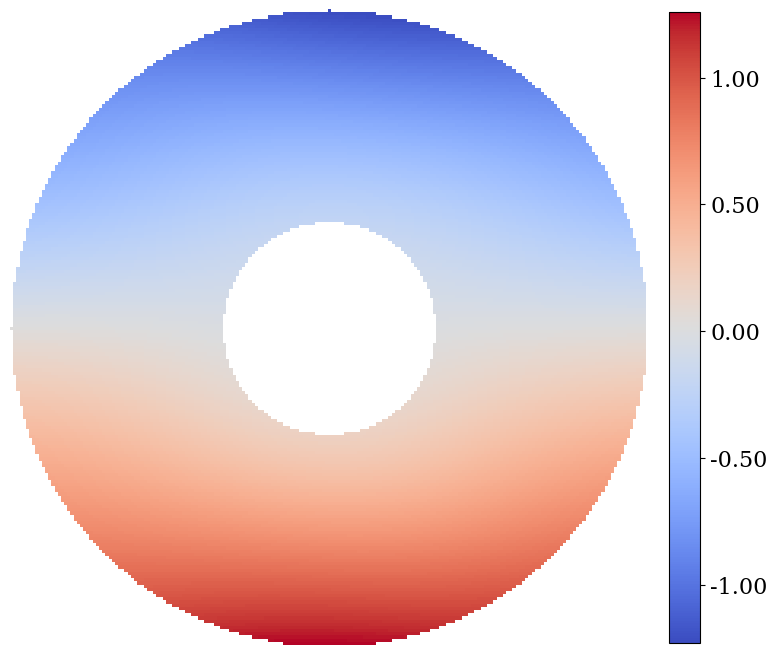

In [65]:
fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,alcout,format="%.2f")
plt.show()

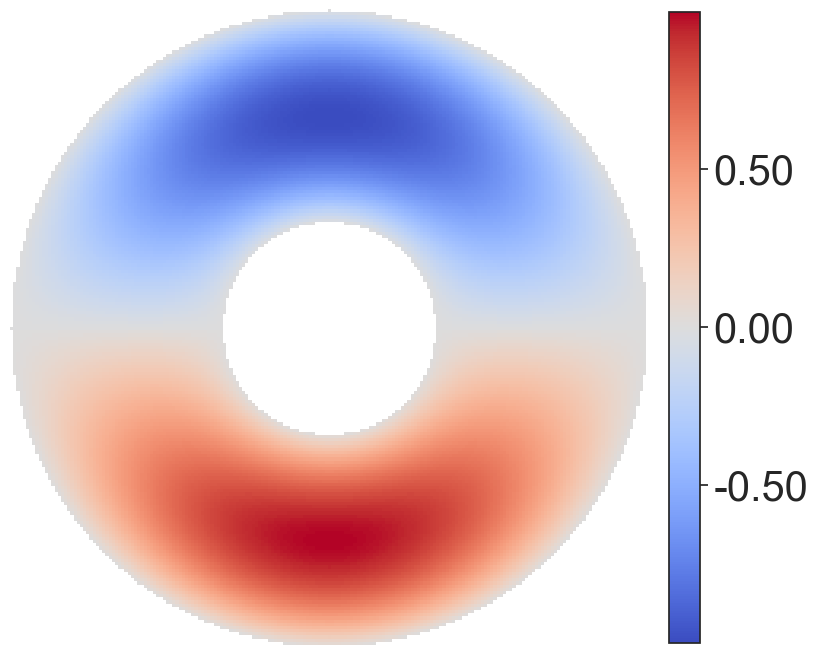

In [17]:
fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,c_plot_values,format="%.2f",labelfs=30)
plt.show()

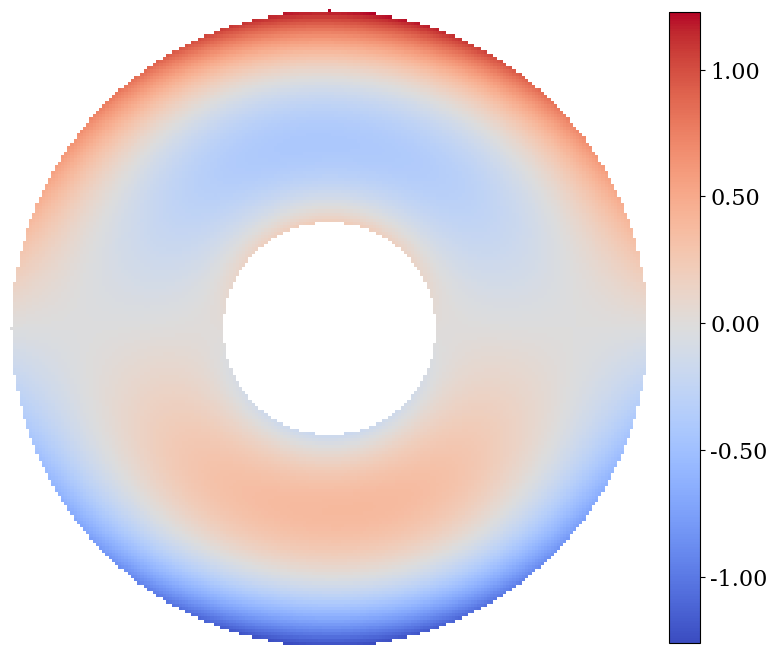

In [67]:
fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,c_plot_values-alcout,format="%.2f")
plt.show()

In [76]:
Lmerr

[0.00025615571426909313,
 0.07548379566890127,
 8.771149417855877e-05,
 0.045103349609443726,
 0.011322559628386674,
 0.9813478369824992,
 0.01217945422348511,
 1.1042801588671973]

In [77]:
L2err

[0.00013486959420813249,
 0.028349219486515913,
 4.5245351623077936e-05,
 0.013381201759361333,
 0.007748148270767096,
 0.545121108980488,
 0.007697633984074744,
 0.5502065219975901]

In [37]:
with open("/Users/dual/Documents/simu/LinearPoissonUC/forward_test/bw0.09999999999999998/testbw0.09999999999999998.pkl",'rb') as pfile:
    bw01 = pkl.load(pfile)
with open("/Users/dual/Documents/simu/LinearPoissonUC/forward_test/bw0.19999999999999996/testbw0.19999999999999996.pkl",'rb') as pfile:
    bw02 = pkl.load(pfile)
with open("/Users/dual/Documents/simu/LinearPoissonUC/forward_test/bw0.30000000000000004/testbw0.30000000000000004.pkl",'rb') as pfile:
    bw03 = pkl.load(pfile)
with open("/Users/dual/Documents/simu/LinearPoissonUC/forward_test/bw0.4/testbw0.4.pkl",'rb') as pfile:
    bw04 = pkl.load(pfile)
with open("/Users/dual/Documents/simu/LinearPoissonUC/forward_test/bw0.5/testbw0.5.pkl",'rb') as pfile:
    bw05 = pkl.load(pfile)
with open("/Users/dual/Documents/simu/LinearPoissonUC/forward_test/bw0.6/testbw0.6.pkl",'rb') as pfile:
    bw06 = pkl.load(pfile)
with open("/Users/dual/Documents/simu/LinearPoissonUC/forward_test/bw0.7/testbw0.7.pkl",'rb') as pfile:
    bw07 = pkl.load(pfile)
with open("/Users/dual/Documents/simu/LinearPoissonUC/forward_test/bw0.8/testbw0.8.pkl",'rb') as pfile:
    bw08 = pkl.load(pfile)
with open("/Users/dual/Documents/simu/LinearPoissonUC/forward_test/bw0.9/testbw0.9.pkl",'rb') as pfile:
    bw09 = pkl.load(pfile)
with open("/Users/dual/Documents/simu/LinearPoissonUC/forward_test/bw0.99/testbw0.99.pkl",'rb') as pfile:
    bw099 = pkl.load(pfile)
with open("/Users/dual/Documents/simu/LinearPoissonUC/forward_test/bw0.999/testbw0.999.pkl",'rb') as pfile:
    bw0999 = pkl.load(pfile)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/dual/Documents/simu/LinearPoissonUC/forward_test/bw0.09999999999999998/testbw0.09999999999999998.pkl'

In [ ]:
errdat = pd.DataFrame({"0.1":bw01,'0.2':bw02,"0.3":bw03,'0.4':bw04,"0.5":bw05,"0.6":bw06,'0.7':bw07,'0.8':bw08,'0.9':bw09,"0.99":bw099,"0.999":bw0999})

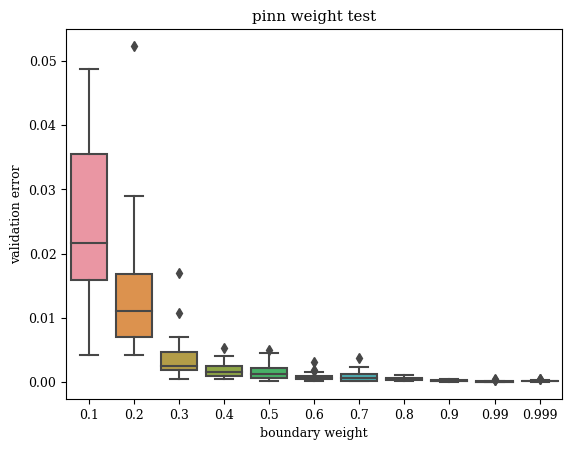

In [ ]:
sns.boxplot(errdat)
plt.ylabel("validation error")
plt.xlabel("boundary weight")
plt.title("pinn weight test")
plt.savefig("pinnweighttest.png",dpi=400)

In [ ]:
vulist = []
vclist = []
for datanum in range(10):
    tu = []
    tc = []
    for testnum in range(12):
        with open("/Users/dual/Documents/simu/LinearPoissonUC/ctresult/datasize{}/test{}/expInfo.json".format(datanum,testnum)) as jfile:
            info = json.load(jfile)
            tu.append(info["lastvu"])
            tc.append(info["lastvc"])
    vulist.append(tu)
    vclist.append(tc)

In [ ]:
udat = pd.DataFrame(vulist).transpose()

In [ ]:
udat

,0,1,2,3,4,5,6,7,8,9
0,0.303235,0.000301,0.001089,0.001390,0.000680,0.000263,0.000723,0.000636,0.000581,0.000309
1,0.362432,0.000409,0.000219,0.000617,0.001332,0.000429,0.001284,0.000199,0.000821,0.000305
2,0.379941,0.000524,0.000291,0.000509,0.000449,0.001224,0.000647,0.000520,0.000250,0.000508
3,0.466247,0.000432,0.000467,0.000790,0.000789,0.000058,0.000597,0.000756,0.000263,0.000562
4,0.298332,0.001118,0.000971,0.000302,0.001493,0.000767,0.000717,0.000469,0.000454,0.000286
5,0.528615,0.000887,0.000390,0.000752,0.000431,0.000328,0.000310,0.001011,0.000440,0.000216
6,0.189117,0.000588,0.000660,0.000086,0.000616,0.000390,0.000620,0.001106,0.000516,0.000392
7,0.329207,0.001039,0.001939,0.000814,0.000966,0.000568,0.000312,0.000695,0.000377,0.000251
8,0.353527,0.000457,0.000353,0.000564,0.000492,0.000343,0.000293,0.000258,0.000306,0.001963
9,0.390688,0.000752,0.001678,0.000308,0.000526,0.001059,0.000282,0.000511,0.000563,0.000534


In [ ]:
tmp = [[250,2],[500,4], [1000, 8], [1500, 12], [2000, 16], [4000, 32], [6000, 48], [8000, 64], [10000, 80], [15000, 120], [20000, 160], [30000, 240], [40000, 320], [60000, 480], [80000, 640], [100000, 800]]
colname = [str(i[0]) for i in tmp[0:10]]
print(colname)

['250', '500', '1000', '1500', '2000', '4000', '6000', '8000', '10000', '15000']


In [ ]:
udat.columns = colname

In [ ]:
def logfunc(x):
    return np.log10(x)
logudat = udat.apply(logfunc)

In [ ]:
logudat

,250,500,1000,1500,2000,4000,6000,8000,10000,15000
0,-0.518221,-3.521884,-2.962778,-2.856844,-3.167615,-3.580202,-3.140928,-3.196598,-3.236177,-3.510594
1,-0.440774,-3.388093,-3.660088,-3.210063,-2.875340,-3.367161,-2.891484,-3.701251,-3.085538,-3.515594
2,-0.420283,-3.280780,-3.536006,-3.293287,-3.347324,-2.912335,-3.188923,-3.284072,-3.602736,-3.294358
3,-0.331384,-3.364518,-3.330770,-3.102561,-3.103065,-4.239358,-3.223865,-3.121328,-3.580186,-3.250301
4,-0.525301,-2.951414,-3.012952,-3.519807,-2.825938,-3.115461,-3.144646,-3.329008,-3.343387,-3.543858
5,-0.276860,-3.052306,-3.408514,-3.123850,-3.365849,-3.483928,-3.508360,-2.995107,-3.356426,-3.664807
6,-0.723270,-3.230543,-3.180498,-4.063474,-3.210109,-3.408854,-3.207830,-2.956253,-3.287661,-3.406797
7,-0.482531,-2.983433,-2.712466,-3.089308,-3.014909,-3.245518,-3.505557,-3.158312,-3.423175,-3.599467
8,-0.451578,-3.339920,-3.452061,-3.248434,-3.308287,-3.465316,-3.533810,-3.588343,-3.514527,-2.707124
9,-0.408169,-3.123970,-2.775251,-3.511589,-3.279195,-2.975115,-3.550064,-3.291679,-3.249144,-3.272149


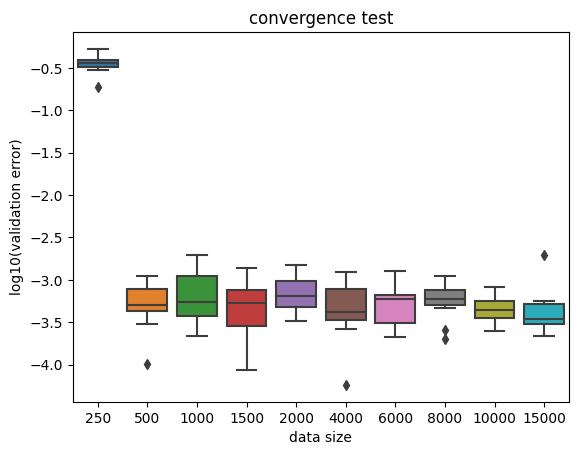

In [ ]:
sns.boxplot(logudat)
plt.ylabel("log10(validation error)")
plt.xlabel("data size")
plt.title("convergence test")
plt.savefig("convergeplot.png",dpi=400)

In [21]:
sns.set_theme(style='white')
def plot_2D_data(fig,ax,data,title="",xlabel="",ylabel="",barlabel="",format=None,titlefs=25,labelfs=45,normminmax=None,is_colorbar = True):
    mpl.rcParams['font.size'] = titlefs
    plot_data = data.copy()
    plot_data[mask] = np.nan
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_axis_off()
    mpl.rcParams['font.size'] = labelfs
    if is_colorbar:
        if normminmax is not None:
            im = ax.imshow(plot_data,cmap=cm.coolwarm,norm=mpl.colors.Normalize(vmin=normminmax[0], vmax=normminmax[1]))
            cbar = fig.colorbar(im, ax=ax, label=barlabel,shrink=0.82,pad=0.03,format=format,spacing="proportional",norm=mpl.colors.Normalize(vmin=normminmax[0], vmax=normminmax[1]))
        else:
            im = ax.imshow(plot_data,cmap=cm.coolwarm)
            cbar = fig.colorbar(im, ax=ax, label=barlabel,shrink=0.82,pad=0.03,format=format,spacing="proportional")
        cbar.ax.tick_params(labelsize=labelfs)

def plot_2D_func(net,*args,**kwargs):
    pt_u = net(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])
    plot_2D_data(data=pt_u,*args,**kwargs)

def plot_err(net,data,*args,**kwargs):
    pt_u = net(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])
    err = np.abs(pt_u-data)
    plot_2D_data(data = err,*args,**kwargs)

In [36]:
sns.set_theme(style='white')
def plot_2D_data(fig,ax,data,title="",xlabel="",ylabel="",barlabel="",format=None,titlefs=25,labelfs=45,normminmax=None,is_colorbar = True):
    mpl.rcParams['font.size'] = titlefs
    plot_data = data.copy()
    plot_data[mask] = np.nan
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_axis_off()
    mpl.rcParams['font.size'] = labelfs
    if is_colorbar:
        if normminmax is not None:
            im = ax.imshow(plot_data,cmap=cm.coolwarm,norm=mpl.colors.Normalize(vmin=normminmax[0], vmax=normminmax[1]))
            cbar = fig.colorbar(im, ax=ax, label=barlabel,shrink=0.82,pad=0.03,format=format,spacing="proportional",norm=mpl.colors.Normalize(vmin=normminmax[0], vmax=normminmax[1]))
        else:
            im = ax.imshow(plot_data,cmap=cm.coolwarm)
            cbar = fig.colorbar(im, ax=ax, label=barlabel,shrink=0.82,pad=0.03,format=format,spacing="proportional")
        cbar.ax.tick_params(labelsize=labelfs)

def plot_2D_func(net,*args,**kwargs):
    pt_u = net(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])
    plot_2D_data(data=pt_u,*args,**kwargs)

def plot_err(net,data,*args,**kwargs):
    pt_u = net(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])
    err = np.abs(pt_u-data)
    plot_2D_data(data = err,*args,**kwargs)

mpl.rcdefaults()
mpl.rcParams['font.family']='serif'
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.variant'] = 'normal'
mpl.rcParams['font.weight'] = 'book'
mpl.rcParams['font.size'] = 16

dpi = 200
pad_inches = 0.1

cout = torch.clamp(cc(t_val_vx,t_val_vy)*(-100.0),-999999,9999999.0).detach().numpy().reshape([Nv,Nv])
aout = AONN_c(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])

nmax = np.nanmax([np.nanmax(cout[~mask]),np.nanmax(aout[~mask]),np.nanmax(c_plot_values),np.nanmax(pc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])[~mask]),np.nanmax(alc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])[~mask])])
nmin = np.nanmin([np.nanmin(cout[~mask]),np.nanmin(aout[~mask]),np.nanmin(c_plot_values),np.nanmin(pc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])[~mask]),np.nanmin(alc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])[~mask])])

print(nmax,nmin)
fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,cout,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("coupled_ctrl.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,aout,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("AONN_ctrl.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_func(pc,fig=fig,ax=ax,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("penalty_ctrl.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_func(fig=fig,ax=ax,net = alc,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("auglag_ctrl.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,c_plot_values,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("analytical_ctrl.png",dpi=dpi,bbox_inches='tight',pad_inches=pad_inches)
plt.close()

####
'''nmax = np.max([np.max(u_plot_values),np.max(cu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.max(AONN_u(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.max(pu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.max(alu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]))])
nmin = np.min([np.min(u_plot_values),np.min(cu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.min(AONN_u(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.min(pu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.min(alu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]))])'''
nmax = np.nanmax([np.nanmax(u_plot_values),np.nanmax(cu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])[~mask]),np.nanmax(AONN_u(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])[~mask]),np.nanmax(pu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])[~mask]),np.nanmax(alu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])[~mask])])
nmin = np.nanmin([np.nanmin(u_plot_values),np.nanmin(cu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])[~mask]),np.nanmin(AONN_u(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])[~mask]),np.nanmin(pu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])[~mask]),np.nanmin(alu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])[~mask])])

print(nmax,nmin)
fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,cu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]),format="%.2f",normminmax=[nmin,nmax])
plt.savefig("coupled_state.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,AONN_u(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]),format="%.2f",normminmax=[nmin,nmax])
plt.savefig("AONN_state.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,pu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]),format="%.2f",normminmax=[nmin,nmax])
plt.savefig("penalty_state.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,alu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]),format="%.2f",normminmax=[nmin,nmax])
plt.savefig("auglag_state.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,u_plot_values,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("analytical_state.png",dpi=dpi,bbox_inches='tight',pad_inches=pad_inches)
plt.close()

####
#nmax = np.max([np.max(np.abs(cout-c_plot_values)),np.max(np.abs(aout-c_plot_values)),np.max(np.abs(pc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-c_plot_values)),np.max(np.abs(alc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-c_plot_values))])
#nmin = np.min([np.min(np.abs(cout-c_plot_values)),np.min(np.abs(aout-c_plot_values)),np.min(np.abs(pc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-c_plot_values)),np.min(np.abs(alc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-c_plot_values))])
nmax = np.nanmax([np.nanmax(np.abs(cout-c_plot_values)),np.nanmax(np.abs(aout-c_plot_values)),np.nanmax(np.abs(pc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-c_plot_values)),np.nanmax(np.abs(alc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-c_plot_values))])
nmin = np.nanmin([np.nanmin(np.abs(cout-c_plot_values)),np.nanmin(np.abs(aout-c_plot_values)),np.nanmin(np.abs(pc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-c_plot_values)),np.nanmin(np.abs(alc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-c_plot_values))])

print(nmax,nmin)
fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,np.abs(cout-c_plot_values),format="%.2f",normminmax=[nmin,nmax])
plt.savefig("coupled_ctrl_err.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,np.abs(aout-c_plot_values),format="%.2f",normminmax=[nmin,nmax])
plt.savefig("AONN_ctrl_err.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_err(fig=fig,ax=ax,net=pc,data=c_plot_values,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("penalty_ctrl_err.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_err(fig=fig,ax=ax,net=alc,data=c_plot_values,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("auglag_ctrl_err.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

####
nmax = np.nanmax([np.nanmax(np.abs(cu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-u_plot_values)),np.nanmax(np.abs(AONN_u(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-u_plot_values)),np.nanmax(np.abs(pu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-u_plot_values)),np.nanmax(np.abs(alu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-u_plot_values))])
nmin = np.nanmin([np.nanmin(np.abs(cu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-u_plot_values)),np.nanmin(np.abs(AONN_u(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-u_plot_values)),np.nanmin(np.abs(pu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-u_plot_values)),np.nanmin(np.abs(alu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-u_plot_values))])

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_err(fig=fig,ax=ax,net=cu,data=u_plot_values,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("coupled_state_err.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_err(fig=fig,ax=ax,net=AONN_u,data=u_plot_values,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("AONN_state_err.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_err(fig=fig,ax=ax,net=pu,data=u_plot_values,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("penalty_state_err.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_err(fig=fig,ax=ax,net=alu,data=u_plot_values,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("auglag_state_err.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()


1.0060857101937364 -1.0280413958593586
9.000418665216625 1.0020006993786112
0.183254085817352 4.8592292856142194e-08


In [26]:
np.nanmax(cu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]))

17.4196098461574

In [27]:
tmp = cu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])

In [32]:
np.nanmax(tmp[~mask])

9.000418665216625

In [ ]:
#nmin = np.min([np.min(np.abs(u_plot_values-cu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]))),np.min(np.abs(u_plot_values-AONN_u(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]))),np.min(np.abs(u_plot_values-pu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]))),np.min(np.abs(u_plot_values-alu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])))])

In [2]:
with open("/Users/dual/Documents/simu/LinearEx2/results/AL/t1/hist.pkl",'rb') as pfile:
    hist = pkl.load(pfile)

In [6]:
print(hist.costhist[-1])

0.16419776294946645


dict_keys(['losslist', 'pdehist', 'pderes', 'pdebc', 'adjhist', 'adjres', 'adjbc', 'vhist_y', 'vhist_u', 'costhist', 'epoch', 'best_pinnloss'])


dict_keys(['pdehist', 'pderes', 'pdebc', 'adjhist', 'adjres', 'adjbc', 'vhist_y', 'vhist_u', 'costhist', 'epoch'])


59


140


855


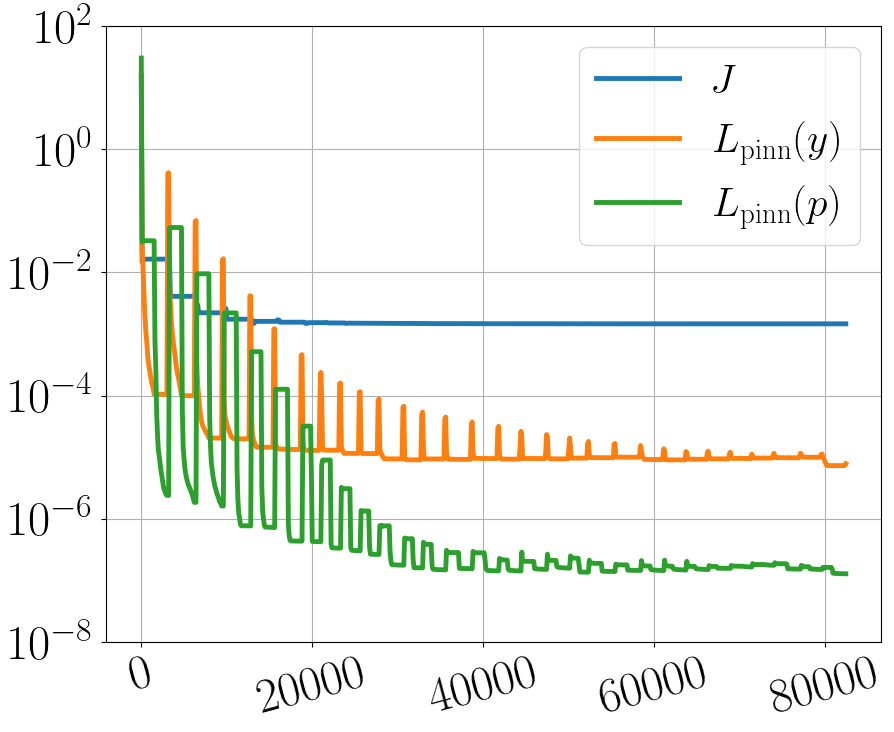

dict_keys(['losslist', 'pdehist', 'pderes', 'pdebc', 'vhist_y', 'vhist_u', 'epoch', 'costhist', 'best_pinnloss'])


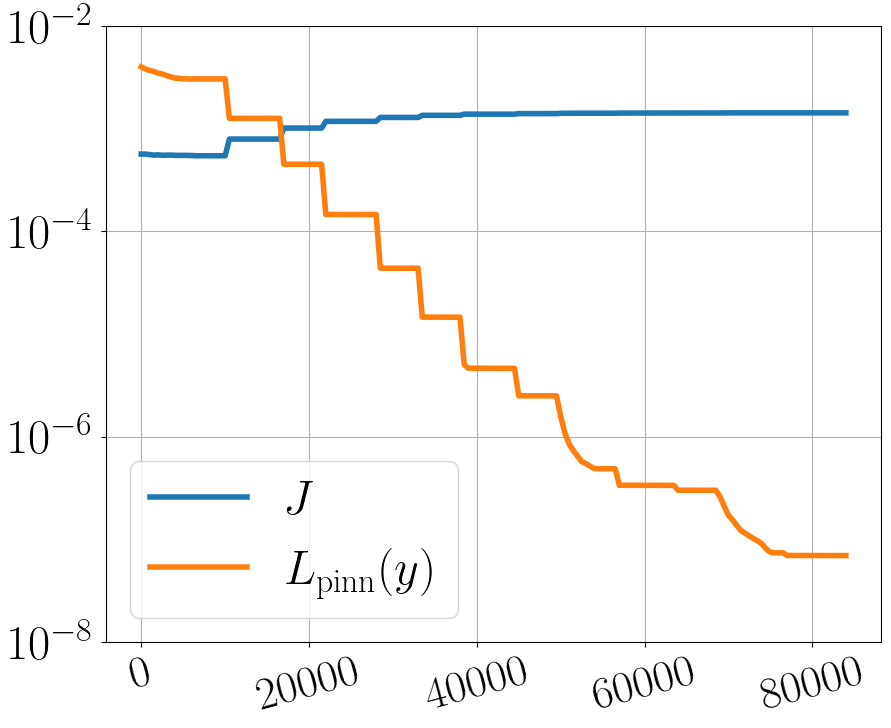

dict_keys(['losslist', 'pdehist', 'pderes', 'pdebc', 'vhist_y', 'vhist_u', 'epoch', 'costhist', 'best_pinnloss'])


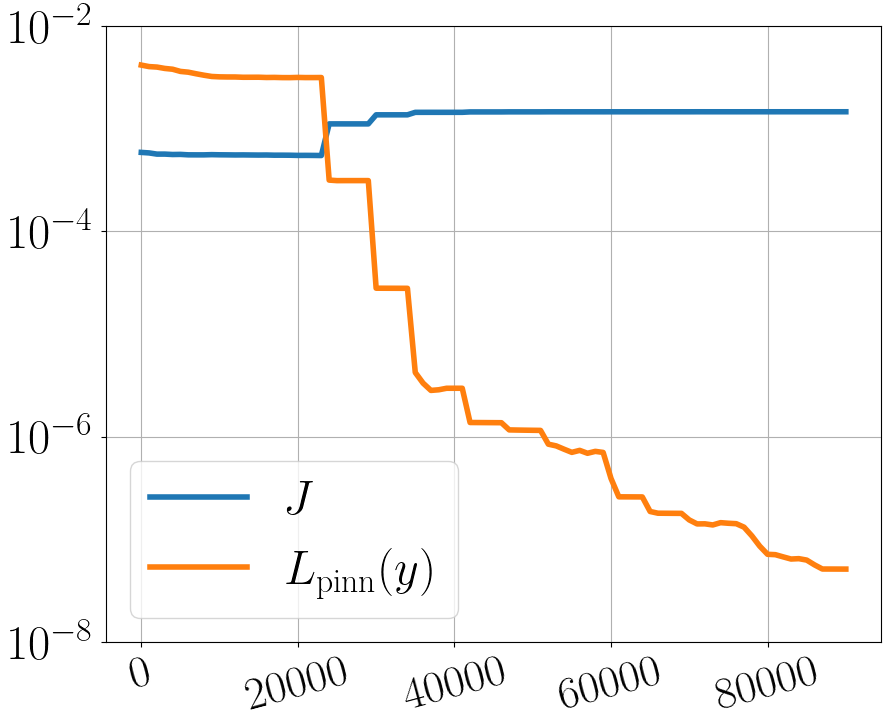

dict_keys(['losslist', 'pdehist', 'pderes', 'pdebc', 'adjhist', 'adjres', 'adjbc', 'vhist_y', 'vhist_u', 'costhist', 'epoch', 'best_pinnloss'])


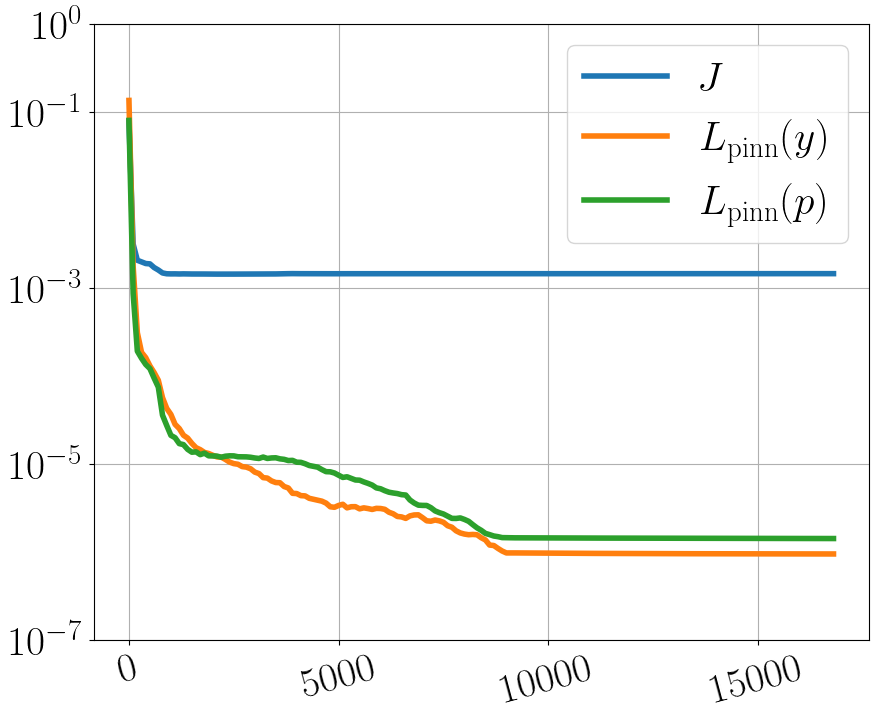

In [53]:
with open("/Users/dual/Documents/cpinn_backup_20230624/LinearEx2_annulus/results/cpinn/t2/hist.pkl",'rb') as pfile:
    hist = pkl.load(pfile)

print(hist.__dict__.keys())

iter_ticks = [100*i for i in range(len(hist.pderes))]
y_ticks = [10**(-i-1) for i in range(7)]
plt.loglog(iter_ticks,hist.pderes)
plt.loglog(iter_ticks,hist.pdebc)
#plt.xlabel("iteration")
plt.yticks(y_ticks)
plt.ylim(10**(-7),10**(-1))
plt.legend(["PDE residual","BC residual"])
plt.savefig("figures/primal_pde_resdyn.png",dpi=300,bbox_inches="tight")
plt.close()

plt.loglog(iter_ticks,hist.adjres)
plt.loglog(iter_ticks,hist.adjbc)
plt.yticks(y_ticks)
plt.ylim(10**(-7),10**(-1))
#plt.xlabel("iteration")
plt.legend(["PDE residual","BC residual"])
plt.savefig("figures/adjoint_pde_resdyn.png",dpi=300,bbox_inches="tight")
plt.close()

plt.loglog(hist.losslist)
#plt.xlabel("iteration")
plt.savefig("figures/traindyn.png",dpi=300,bbox_inches="tight")
plt.close()

with open("/Users/dual/Documents/cpinn_backup_20230624/LinearEx2_annulus/results/AONN/t10/hist.pkl",'rb') as pfile:
    hist = pkl.load(pfile)

print(hist.__dict__.keys())

def incfunc(input):
    tmp = [True if input[i+1]>input[i] else False for i in range(len(input)-1)]
    tmp.append(True)
    return tmp

pind = incfunc(hist.pdehist)
aind = incfunc(hist.adjhist)

tmp2 = np.array(hist.pdehist)
phist = tmp2[pind]
print(len(phist))

tmp2 = np.array(hist.adjhist)
ahist = tmp2[aind]
print(len(ahist))

print(len(hist.costhist))

plt.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.figure(figsize=[10,8])
mpl.rcParams['font.size'] = 22
#plt.plot([i+1 for i in range(25)],phist[0:25],marker='s',linewidth=3.5,markersize=8,linestyle='--')
#plt.plot([i+1 for i in range(25)],ahist[0:25],marker='o',markersize = 8,linewidth = 3.5,linestyle='--')
plt.plot([i*100 for i in range(len(hist.pderes))],hist.costhist[0:825],linewidth = 3.5)
plt.plot([i*100 for i in range(len(hist.pderes))],hist.pderes,linewidth = 3.5)
plt.plot([i*100 for i in range(len(hist.pderes))],hist.adjres,linewidth = 3.5)
plt.yscale('log')
plt.grid()
plt.ylim(10**(-8),10**(2))
plt.legend(["$J$",r'$L_{\text{pinn}}(y)$',r'$L_{\text{pinn}}(p)$'],fontsize=30,loc='upper right')
plt.yticks(fontsize=35)
#plt.xlabel("outer iterations")
plt.xticks(rotation=15,fontsize=35)
plt.savefig("figures/AONNhist_alter.png",dpi=400,bbox_inches="tight")
plt.show()

with open("/Users/dual/Documents/cpinn_backup_20230624/LinearEx2_annulus/results/penalty/t9/hist.pkl",'rb') as pfile:
    hist = pkl.load(pfile)

print(hist.__dict__.keys())

fig,ax = plt.subplots(figsize=[10,8])
plt.plot([500*i for i in range(len(hist.costhist))],hist.costhist,linewidth=4)
plt.plot([500*i for i in range(len(hist.costhist))],hist.pdehist,linewidth = 4)
plt.yscale('log')
plt.grid()
plt.ylim(10**(-8),10**(-2))
'''ax.axvline(x=7800,linewidth=1.2,linestyle='--',color='gray')
ax.axvline(x=15800,linewidth=1.2,linestyle='--',color='gray')
ax.axvline(x=23300,linewidth=1.2,linestyle='--',color='gray')
ax.axvline(x=30800,linewidth=1.2,linestyle='--',color='gray')
ax.axvline(x=38300,linewidth=1.2,linestyle='--',color='gray')
plt.grid(axis='y',linewidth=1.2,linestyle='--',color='gray')'''
plt.legend(["$J$",r"$L_\text{pinn}(y)$"],fontsize=35)
#plt.show()
mpl.rcParams['font.size'] = 35
plt.yticks(fontsize=35)
plt.xticks(rotation=15,fontsize=33)
#plt.xlabel("training epoch")
plt.savefig("figures/penaltyhist.png",dpi=400,bbox_inches="tight")
plt.show()

with open("/Users/dual/Documents/cpinn_backup_20230624/LinearEx2_annulus/results/AL/t12/hist.pkl",'rb') as pfile:
    hist = pkl.load(pfile)

print(hist.__dict__.keys())

plt.figure(figsize=[10,8])
plt.plot([1000*i for i in range(len(hist.costhist))],hist.costhist,linewidth=4)
plt.plot([1000*i for i in range(len(hist.costhist))],hist.pdehist,linewidth =4)
plt.yscale('log')
#plt.xlim(-,59999)
plt.ylim(10**(-8),10**(-2))
plt.grid()
mpl.rcParams['font.size'] = 35
plt.xticks(rotation=15,fontsize=33)
plt.yticks(fontsize=35)
plt.legend(["$J$",r"$L_\text{pinn}(y)$"],fontsize=35)
#plt.show()
#plt.xlabel("training epoch")
plt.savefig("figures/ALhist.png",dpi=400,bbox_inches="tight")
plt.show()

with open("/Users/dual/Documents/cpinn_backup_20230624/LinearEx2_annulus/results/cpinn/t4/hist.pkl",'rb') as pfile:
    hist = pkl.load(pfile)

print(hist.__dict__.keys())

plt.figure(figsize=[10,8])
plt.plot([100*i for i in range(len(hist.costhist))],hist.costhist,linewidth=4)
plt.plot([100*i for i in range(len(hist.costhist))],hist.pdehist,linewidth = 4)
plt.plot([100*i for i in range(len(hist.costhist))],hist.adjhist,linewidth = 4)
plt.yscale('log')
plt.grid()
plt.ylim(10**(-7),10**(0))

mpl.rcParams['font.size'] = 35
plt.legend(["$J$",r"$L_\text{pinn}(y)$",r"$L_\text{pinn}(p)$"],fontsize=30)
#plt.show()
#plt.xlabel("training epoch")
plt.yticks([1e-7,1e-5,1e-3,1e-1,1],fontsize=30)
plt.xticks(rotation=15,fontsize=30)
plt.savefig("figures/cpinnhist.png",dpi=400,bbox_inches="tight")
plt.show()

In [16]:
dataname = "10000points_frd2"
with open("dataset/"+dataname,'rb') as pfile:
    d_c = pkl.load(pfile)
    b_c = pkl.load(pfile)
    c_c = pkl.load(pfile)
print(d_c.shape,b_c.shape,c_c.shape)

dx1,dx2 = np.split(d_c,2,axis=1)
bx1,bx2 = np.split(b_c,2,axis=1)
cx1,cx2 = np.split(c_c,2,axis=1)


#For simul, no cost evaluation, and we need data on whole domain.

tdx1,tdx2,tbx1,tbx2,tcx1,tcx2 = tools.from_numpy_to_tensor([dx1,dx2,bx1,bx2,cx1,cx2],[True,True,False,False,False,False])


with open("dataset/gt_on_{}".format(dataname),'rb') as pfile:
    y_gt = pkl.load(pfile)
    u_gt = pkl.load(pfile)
    p_gt = pkl.load(pfile)
    y_dat_np = pkl.load(pfile)
    f_np = pkl.load(pfile)
    bdry_np = pkl.load(pfile)

f,y_dat,bdrydat_prim = tools.from_numpy_to_tensor([f_np,y_dat_np,bdry_np],[False,False,False])
bdrydat_adj = torch.zeros([len(tbx1),1])

c_cpinn = pde.cost_mse(cu,y_dat,cc(tdx1,tdx2)*(-100),0.01,tdx1,tdx2)
c_AONN = pde.cost_mse(AONN_u,y_dat,AONN_c(tdx1,tdx2),0.01,tdx1,tdx2)
c_pm = pde.cost_mse(pu,y_dat,pc(tdx1,tdx2),0.01,tdx1,tdx2)
c_alm = pde.cost_mse(alu,y_dat,alc(tdx1,tdx2),0.01,tdx1,tdx2)
print(c_cpinn.detach().numpy(),c_AONN.detach().numpy(),c_pm.detach().numpy(),c_alm.detach().numpy())

(10000, 2) (1000, 2) (2500, 2)
0.0014574080524633797 0.0014600939679523092 0.0014656919889965373 0.0014624333501043743


0.0014574080524633797 0.0014591554536620016 0.0014839777716992185 0.0014652763787118663


In [ ]:
mpl.rcdefaults()
mpl.rcParams['font.family']='serif'
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.variant'] = 'normal'
mpl.rcParams['font.weight'] = 'book'
mpl.rcParams['font.size'] = 16

dpi = 200
pad_inches = 0.1

cout = torch.clamp(cc(t_val_vx,t_val_vy)*(-100.0),-999999,9999999.0).detach().numpy().reshape([Nv,Nv])
aout = AONN_c(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])

'''nmax = np.max([np.max(cout),np.max(aout),np.max(c_plot_values),np.max(pc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.max(alc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]))])
nmin = np.min([np.min(cout),np.min(aout),np.min(c_plot_values),np.min(pc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.min(alc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]))])'''
nmax = np.nanmax([np.nanmax(cout),np.nanmax(aout),np.nanmax(c_plot_values),np.nanmax(pc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.nanmax(alc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]))])
nmin = np.nanmin([np.nanmin(cout),np.nanmin(aout),np.nanmin(c_plot_values),np.nanmin(pc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.nanmin(alc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]))])
print(nmax,nmin)
fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,cout,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("coupled_ctrl.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,aout,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("AONN_ctrl.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_func(pc,fig=fig,ax=ax,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("penalty_ctrl.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_func(fig=fig,ax=ax,net = alc,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("auglag_ctrl.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,c_plot_values,format="%.2f")
plt.savefig("analytical_ctrl.png",dpi=dpi,bbox_inches='tight',pad_inches=pad_inches)
plt.close()

####
'''nmax = np.max([np.max(u_plot_values),np.max(cu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.max(AONN_u(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.max(pu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.max(alu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]))])
nmin = np.min([np.min(u_plot_values),np.min(cu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.min(AONN_u(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.min(pu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.min(alu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]))])'''
print([np.nanmax(u_plot_values),np.nanmax(cu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.nanmax(AONN_u(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.nanmax(pu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.nanmax(alu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]))])

nmax = np.nanmax([np.nanmax(u_plot_values),np.nanmax(cu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.nanmax(AONN_u(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.nanmax(pu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.nanmax(alu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]))])
nmin = np.nanmin([np.nanmin(u_plot_values),np.nanmin(cu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.nanmin(AONN_u(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.nanmin(pu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])),np.nanmin(alu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]))])
print(nmax,nmin)
fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,cu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]),format="%.2f",normminmax=[nmin,nmax])
plt.savefig("coupled_state.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,AONN_u(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]),format="%.2f",normminmax=[nmin,nmax])
plt.savefig("AONN_state.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,pu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]),format="%.2f",normminmax=[nmin,nmax])
plt.savefig("penalty_state.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,alu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]),format="%.2f",normminmax=[nmin,nmax])
plt.savefig("auglag_state.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,u_plot_values,format="%.2f")
plt.savefig("analytical_state.png",dpi=dpi,bbox_inches='tight',pad_inches=pad_inches)
plt.close()

####
#nmax = np.max([np.max(np.abs(cout-c_plot_values)),np.max(np.abs(aout-c_plot_values)),np.max(np.abs(pc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-c_plot_values)),np.max(np.abs(alc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-c_plot_values))])
#nmin = np.min([np.min(np.abs(cout-c_plot_values)),np.min(np.abs(aout-c_plot_values)),np.min(np.abs(pc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-c_plot_values)),np.min(np.abs(alc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-c_plot_values))])
nmax = np.nanmax([np.nanmax(np.abs(cout-c_plot_values)),np.nanmax(np.abs(aout-c_plot_values)),np.nanmax(np.abs(pc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-c_plot_values)),np.nanmax(np.abs(alc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-c_plot_values))])
nmin = np.nanmin([np.nanmin(np.abs(cout-c_plot_values)),np.nanmin(np.abs(aout-c_plot_values)),np.nanmin(np.abs(pc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-c_plot_values)),np.nanmin(np.abs(alc(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])-c_plot_values))])

print(nmax,nmin)
fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,np.abs(cout-c_plot_values),format="%.2f",normminmax=[nmin,nmax])
plt.savefig("coupled_ctrl_err.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_2D_data(fig,ax,np.abs(aout-c_plot_values),format="%.2f",normminmax=[nmin,nmax])
plt.savefig("AONN_ctrl_err.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_err(fig=fig,ax=ax,net=pc,data=c_plot_values,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("penalty_ctrl_err.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_err(fig=fig,ax=ax,net=alc,data=c_plot_values,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("auglag_ctrl_err.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

####
nmax = np.nanmax([np.nanmax(np.abs(u_plot_values-cu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]))),np.nanmax(np.abs(u_plot_values-AONN_u(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]))),np.nanmax(np.abs(u_plot_values-pu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]))),np.nanmax(np.abs(u_plot_values-alu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])))])
nmin = np.nanmin([np.nanmin(np.abs(u_plot_values-cu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]))),np.nanmin(np.abs(u_plot_values-AONN_u(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]))),np.nanmin(np.abs(u_plot_values-pu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv]))),np.nanmin(np.abs(u_plot_values-alu(t_val_vx,t_val_vy).detach().numpy().reshape([Nv,Nv])))])
print(nmax,nmin)

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_err(fig=fig,ax=ax,net=cu,data=u_plot_values,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("coupled_state_err.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_err(fig=fig,ax=ax,net=AONN_u,data=u_plot_values,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("AONN_state_err.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_err(fig=fig,ax=ax,net=pu,data=u_plot_values,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("penalty_state_err.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()

fig, ax = plt.subplots(1,1,figsize=[10,10])
plot_err(fig=fig,ax=ax,net=alu,data=u_plot_values,format="%.2f",normminmax=[nmin,nmax])
plt.savefig("auglag_state_err.png",dpi=dpi,bbox_inches="tight",pad_inches=pad_inches)
plt.close()
